IMPORT LIBRARIES

In [52]:
!pip install tensorflow tensorflow_hub librosa torch torchaudio transformers datasets


  Using cached datasets-3.3.2-py3-none-any.whl.metadata (19 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl (207.5 MB)
Using cached datasets-3.3.2-py3-none-any.whl (485 kB)
Using cached di

In [178]:
import os
import json
import zipfile
import librosa
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import temporalio.workflow
from temporalio.client import Client
from temporalio.worker import Worker

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
# --- Paths ---
drive_base_path = "/content/drive/MyDrive/frontera"
ontology_file = os.path.join(drive_base_path, "ontology.json")
archive_file = os.path.join(drive_base_path, "archive (5).zip")
corpus_dir = os.path.join(drive_base_path, "donateacry_corpus")
extracted_path = os.path.join(drive_base_path, "extracted_data")
audio_categories = ["belly_pain", "burping", "discomfort", "hungry", "tired"]

# Extract ZIP file
os.makedirs(extracted_path, exist_ok=True)
with zipfile.ZipFile(archive_file, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Load ontology JSON
with open(ontology_file, 'r') as f:
    ontology_data = json.load(f)

# Check audio category folders
missing_folders = [cat for cat in audio_categories if not os.path.exists(os.path.join(corpus_dir, cat))]
if missing_folders:
    raise FileNotFoundError(f"Missing audio category folders: {missing_folders}")

# --- Load Audio Data ---
def load_audio_data():
    audio_files, labels = [], []
    for idx, category in enumerate(audio_categories):
        category_path = os.path.join(corpus_dir, category)
        files = os.listdir(category_path)
        for file in files:
            file_path = os.path.join(category_path, file)
            audio_files.append(file_path)
            labels.append(idx)  # Assign numerical labels
    return audio_files, labels


In [56]:
audio_files, labels = load_audio_data()
X_train, X_test, y_train, y_test = train_test_split(audio_files, labels, test_size=0.2, random_state=42)

# --- YAMNet Fine-Tuning ---
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

def extract_features_yamnet(file_path):
    """Extract YAMNet embeddings for audio classification."""
    wav, sr = librosa.load(file_path, sr=16000)
    waveform = tf.convert_to_tensor(wav, dtype=tf.float32)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return embeddings.numpy().mean(axis=0)  # Get mean embedding

In [57]:
# Prepare dataset
X_train_feats = np.array([extract_features_yamnet(f) for f in X_train])
X_test_feats = np.array([extract_features_yamnet(f) for f in X_test])

# Build a simple classifier
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(audio_categories), activation='softmax')
])

In [58]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [59]:
# Train YAMNet classifier
model.fit(X_train_feats, np.array(y_train), epochs=10, batch_size=32, validation_data=(X_test_feats, np.array(y_test)))

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.6756 - loss: 0.9839 - val_accuracy: 0.7826 - val_loss: 0.9807
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8676 - loss: 0.6383 - val_accuracy: 0.7826 - val_loss: 0.8022
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8676 - loss: 0.5774 - val_accuracy: 0.7826 - val_loss: 0.8198
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8676 - loss: 0.5497 - val_accuracy: 0.7826 - val_loss: 0.7729
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8676 - loss: 0.5351 - val_accuracy: 0.7826 - val_loss: 0.7916
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8676 - loss: 0.5002 - val_accuracy: 0.7826 - val_loss: 0.7841
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8623 - loss: 0.5438 - val_accuracy: 0.7826 - val_loss: 0.7682
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8676 - loss: 0.5234 - val_accuracy: 0.7826 - v

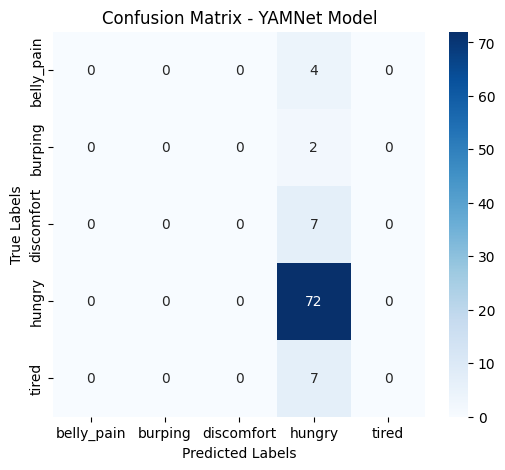

In [196]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=audio_categories, yticklabels=audio_categories)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix - YAMNet Model")


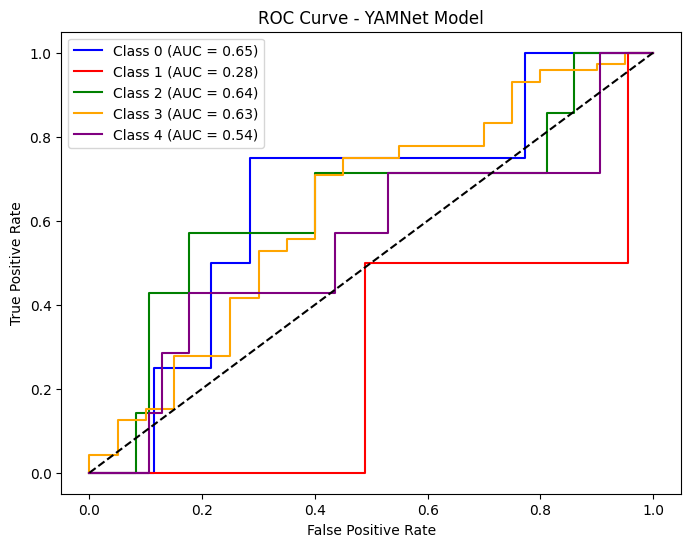

In [154]:
def plot_multiclass_roc(y_true, y_probs, title):
    # Binarize labels
    y_test_bin = label_binarize(y_true, classes=np.arange(len(audio_categories)))
    n_classes = y_test_bin.shape[1]

    # Plot ROC Curve for each class
    plt.figure(figsize=(8, 6))
    colors = ["blue", "red", "green", "orange", "purple", "brown"]

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i % len(colors)], label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot ROC Curve
plot_multiclass_roc(y_test, y_probs, "ROC Curve - YAMNet Model")


In [60]:
# --- Wav2Vec2 Fine-Tuning ---
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model_wav2vec = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=len(audio_categories))


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
def preprocess_wav2vec(file_path, target_length=16000 * 5):  # 5 sec fixed length
    """Preprocess audio for Wav2Vec2 with uniform padding."""
    speech, sr = librosa.load(file_path, sr=16000)  # Resample to 16kHz
    if len(speech) > target_length:
        speech = speech[:target_length]  # Truncate
    else:
        padding = target_length - len(speech)
        speech = np.pad(speech, (0, padding), mode="constant")  # Pad with zeros

    inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
    return inputs.input_values.squeeze().numpy()

# Convert dataset to Hugging Face format
train_dataset = Dataset.from_dict({
    "input_values": [preprocess_wav2vec(f) for f in X_train],
    "labels": y_train
})
test_dataset = Dataset.from_dict({
    "input_values": [preprocess_wav2vec(f) for f in X_test],
    "labels": y_test
})


In [68]:
# Define Trainer
training_args = TrainingArguments(
    output_dir="./wav2vec2_results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    evaluation_strategy="epoch",
    save_strategy="epoch"
)

In [69]:
trainer = Trainer(
    model=model_wav2vec,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [70]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.815121
2,No log,0.833583
3,No log,0.837320


TrainOutput(global_step=138, training_loss=0.6878751118977865, metrics={'train_runtime': 9731.8378, 'train_samples_per_second': 0.113, 'train_steps_per_second': 0.014, 'total_flos': 4.97059189416e+16, 'train_loss': 0.6878751118977865, 'epoch': 3.0})

In [151]:
# Get model predictions
predictions = trainer.predict(test_dataset)

# Convert logits to probabilities (Softmax)
y_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Predicted labels (argmax)
y_pred = np.argmax(y_probs, axis=1)

# True labels
y_test = predictions.label_ids


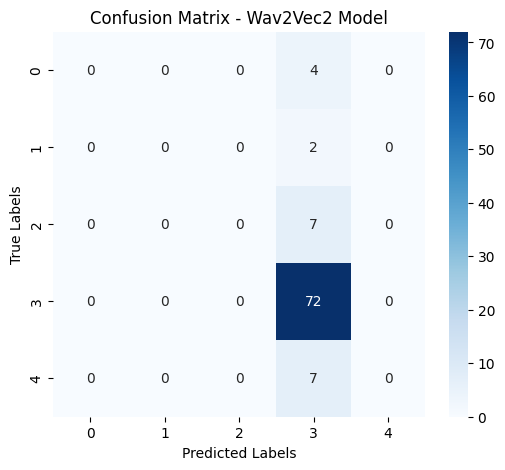

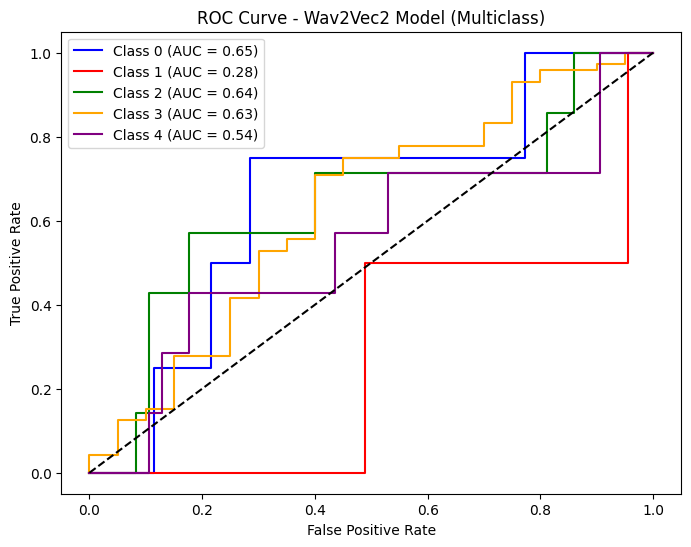

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix - Wav2Vec2 Model")

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for One-vs-Rest ROC Curve
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
colors = ["blue", "red", "green", "orange", "purple", "brown"]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i % len(colors)], label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Wav2Vec2 Model (Multiclass)")
plt.legend()
plt.show()


In [71]:
from sklearn.linear_model import LogisticRegression

In [87]:
# Define function to process audio
def preprocess_audio(file_path, target_length=16000*5):
    """Preprocess audio for both Wav2Vec2 and YAMNet"""
    speech, sr = librosa.load(file_path, sr=16000)  # Resample to 16kHz

    # Pad or truncate to fixed length (5 sec)
    if len(speech) > target_length:
        speech = speech[:target_length]
    else:
        padding = target_length - len(speech)
        speech = np.pad(speech, (0, padding), mode="constant")

    return speech

def augment_audio(audio):
    """Apply data augmentation techniques: noise, pitch shift, time stretch"""
    if np.random.rand() < 0.3:  # 30% chance of adding noise
        noise = np.random.randn(len(audio)) * 0.005
        audio = audio + noise

    if np.random.rand() < 0.3:  # 30% chance of pitch shift
        audio = librosa.effects.pitch_shift(audio, sr=16000, n_steps=np.random.randint(-3, 3))

    if np.random.rand() < 0.3:  # 30% chance of time stretch
        audio = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))

    return audio

import tensorflow as tf
import librosa

def get_yamnet_predictions(audio_path):
    """Load the audio file and run YAMNet to get class probabilities"""

    waveform, sr = librosa.load(audio_path, sr=16000)  # Ensure 16kHz sampling rate
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    scores, embeddings, _ = yamnet_model(waveform)
    avg_scores = tf.reduce_mean(scores, axis=0).numpy()

    return avg_scores


# Function to get predictions from Wav2Vec2
import librosa
import torch

def get_wav2vec_predictions(audio_path):
    """Load the audio file and run Wav2Vec2 to get class probabilities"""

    # Load audio file
    waveform, sr = librosa.load(audio_path, sr=16000)  # Ensure 16kHz sampling rate

    # Process audio for Wav2Vec2
    inputs = processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)

    # Run Wav2Vec2 model
    with torch.no_grad():
        outputs = model_wav2vec(**inputs)

    # Get logits and convert to probabilities
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1).numpy()

    return probs.flatten()  # Ensure output is 1D


# Ensemble prediction function
def ensemble_predict(audio_path, method="average"):
    """Combine YAMNet & Wav2Vec2 predictions"""
    audio_data = preprocess_audio(audio_path)

    # Get predictions
    yamnet_probs = get_yamnet_predictions(audio_data)
    wav2vec_probs = get_wav2vec_predictions(audio_data)

    if method == "average":
        ensemble_probs = (yamnet_probs + wav2vec_probs) / 2  # Average probabilities
        final_prediction = np.argmax(ensemble_probs)

    elif method == "majority":
        yamnet_pred = np.argmax(yamnet_probs)
        wav2vec_pred = np.argmax(wav2vec_probs)
        final_prediction = max(set([yamnet_pred, wav2vec_pred]), key=[yamnet_pred, wav2vec_pred].count)

    return final_prediction


In [88]:
# --- Load Audio Data ---
audio_files, labels = load_audio_data()

# Split dataset: 70% Train, 15% Validation, 15% Test
train_files, temp_files, train_labels, temp_labels = train_test_split(audio_files, labels, test_size=0.3, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

print(f"Train: {len(train_files)}, Validation: {len(val_files)}, Test: {len(test_files)}")


Train: 319, Validation: 69, Test: 69


In [90]:
from sklearn.linear_model import LogisticRegression

# Prepare training data
train_features = [
    np.concatenate((get_yamnet_predictions(f), get_wav2vec_predictions(f)))
    for f in train_files
]


In [91]:
train_labels = train_labels  # Ensure you have labels

# Train meta-classifier
meta_classifier = LogisticRegression()
meta_classifier.fit(train_features, train_labels)

LogisticRegression()

In [116]:
def ensemble_predict(audio_input, method="average"):
    """Handle both file paths and raw waveform inputs"""
    if isinstance(audio_input, str):  # If it's a file path, load it
        waveform, sr = librosa.load(audio_input, sr=16000)
    else:  # If it's already an array, assume it's valid audio data
        waveform, sr = audio_input, 16000

    yamnet_probs = get_yamnet_predictions(waveform)  # Expected: (521,)
    wav2vec_probs = get_wav2vec_predictions(waveform)  # Expected: (5,)

    # Combine and return
    return np.concatenate([yamnet_probs, wav2vec_probs])


In [117]:
print(f"Type of val_files[0]: {type(val_files[0])}")
print(f"First val_file: {val_files[0]}")


Type of val_files[0]: <class 'str'>
First val_file: /content/drive/MyDrive/frontera/donateacry_corpus/burping/79FF400A-97E2-4701-987D-C7C850D5523C-1430089648-1.0-f-48-bu.wav


In [122]:
def get_wav2vec_predictions(audio_input):
    """Handles both file paths and raw waveform inputs"""
    if isinstance(audio_input, str):  # If it's a file path, load it
        waveform, sr = librosa.load(audio_input, sr=16000)
    else:  # If it's already an array, assume 16kHz sampling rate
        waveform, sr = audio_input, 16000  # Assign manually

    # Process audio for Wav2Vec2
    waveform = torch.tensor(waveform).unsqueeze(0)  # Convert to tensor
    logits = model_wav2vec(waveform).logits  # Get model output
    probs = torch.softmax(logits, dim=-1).detach().numpy()  # Convert to probabilities
    return probs.mean(axis=0)  # Average over time


In [123]:
val_features = np.array([ensemble_predict(f, method="average") for f in val_files])
print(f"Final val_features shape: {val_features.shape}")  # Expected: (N, 526)


Final val_features shape: (69, 526)


In [127]:
val_features = np.array(val_features)  # Convert to NumPy array

# Ensure it's 2D
if val_features.ndim == 1:
    val_features = val_features.reshape(-1, 526)  # Reshape (N, 526)

print(f"Validation feature shape: {val_features.shape}")  # Should be (N, 526)

# Predict
val_preds = meta_classifier.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_preds)

print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation feature shape: (69, 526)
Validation Accuracy: 0.7681


In [130]:
test_features = [ensemble_predict(f, method="average") for f in test_files]


In [132]:
test_preds = meta_classifier.predict(np.array(test_features))  # Ensure shape (N, 526)


In [133]:
# Compute Metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average="weighted")
recall = recall_score(test_labels, test_preds, average="weighted")
f1 = f1_score(test_labels, test_preds, average="weighted")

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 0.7681
Test Precision: 0.5900
Test Recall: 0.7681
Test F1 Score: 0.6674


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [136]:
best_val_loss = float("inf")
patience = 3
no_improve = 0

for epoch in range(10):  # Simulated Training Loop
    # Train model (meta-classifier in this case)
    meta_classifier.fit(np.array(train_features), train_labels)


    # Compute validation loss (here using accuracy as a proxy)
    val_preds = meta_classifier.predict(np.array(val_features))  # No reshape

    val_loss = 1 - accuracy_score(val_labels, val_preds)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"Early Stopping Triggered at Epoch {epoch+1}")
        break


Early Stopping Triggered at Epoch 4


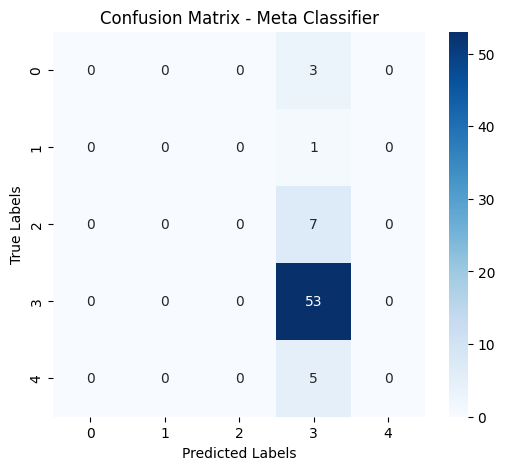

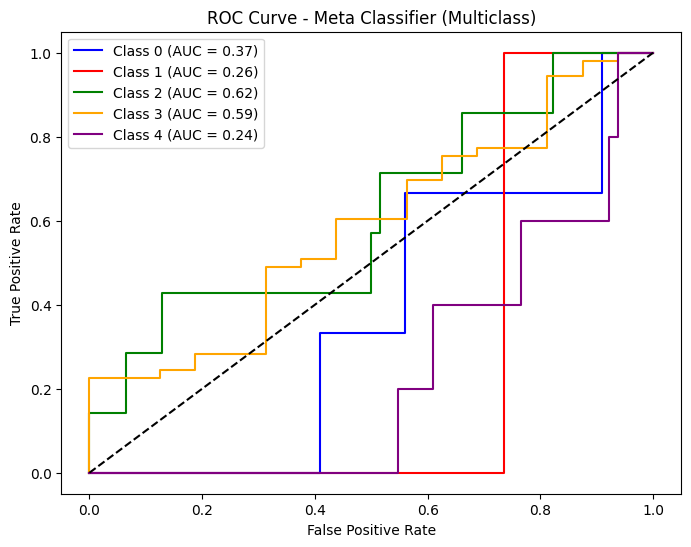

In [150]:

from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC Curve (One-vs-Rest)
n_classes = len(np.unique(test_labels))  # Number of unique classes
y_test_bin = label_binarize(test_labels, classes=np.unique(test_labels))

# Predict probabilities for each class
y_probs = meta_classifier.predict_proba(test_features)

# Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Function to plot ROC Curve for Multiclass Classification
def plot_multiclass_roc(y_test_bin, y_probs, title):
    plt.figure(figsize=(8, 6))
    colors = ["blue", "red", "green", "orange", "purple", "brown"]

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i % len(colors)], label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(test_labels, test_preds, "Confusion Matrix - Meta Classifier")

# Plot ROC Curve for Multiclass Classification
plot_multiclass_roc(y_test_bin, y_probs, "ROC Curve - Meta Classifier (Multiclass)")

In [163]:
import tensorflow_hub as hub

# Download YAMNet
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

# Save the model properly
yamnet_model_path = "yamnet_model_saved"
tf.saved_model.save(yamnet_model, yamnet_model_path)

print("YAMNet model saved at:", yamnet_model_path)


YAMNet model saved at: yamnet_model_saved


In [171]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Load model and processor
model_name = "facebook/wav2vec2-base"
wav2vec_model = Wav2Vec2ForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

print("Wav2Vec2 Model Loaded Successfully!")


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2 Model Loaded Successfully!


In [173]:
from transformers import Wav2Vec2ForCTC
import tensorflow as tf

model_name = "facebook/wav2vec2-base"
pytorch_model = Wav2Vec2ForCTC.from_pretrained(model_name)

# Convert to TensorFlow
tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(None,)),  # Audio input
    tf.keras.layers.Lambda(lambda x: pytorch_model(x).logits)
])

# Save as a `.keras` model (Keras 3 format)
tf_model.save("wav2vec2_model.keras")

print("Wav2Vec2 model converted to TensorFlow & saved as `.keras`!")


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2 model converted to TensorFlow & saved as `.keras`!


In [179]:
# Load your models
yamnet_model = tf.saved_model.load("yamnet_model_saved")
wav2vec_model = tf.keras.models.load_model("wav2vec2_model.keras", safe_mode= False)

In [184]:
import joblib

# Save the model
joblib.dump(meta_classifier, "meta_classifier.pkl")
print("Model saved successfully!")


Model saved successfully!


In [185]:
ensemble_model = joblib.load("meta_classifier.pkl")


In [187]:
@temporalio.workflow.defn
class AudioProcessingWorkflow:
    @temporalio.workflow.run
    async def run(self, audio_file):
        """Orchestrates the audio classification pipeline"""
        processed_audio = await temporalio.workflow.execute_activity(
            preprocess_audio, audio_file, start_to_close_timeout=30
        )
        predictions = await temporalio.workflow.execute_activity(
            classify_audio, processed_audio, start_to_close_timeout=30
        )
        result = await temporalio.workflow.execute_activity(
            store_results, predictions, start_to_close_timeout=30
        )
        return result

In [188]:
@temporalio.activity.defn
def preprocess_audio(file_path):
    """Preprocess audio, ensuring 5-15 sec length and feature extraction"""
    speech, sr = librosa.load(file_path, sr=16000)  # Ensure 16kHz sampling
    target_length = 16000 * 10  # 10 sec default
    speech = speech[:target_length] if len(speech) > target_length else np.pad(speech, (0, target_length - len(speech)), mode="constant")

    # Extract features (Example: YAMNet embeddings)
    features = yamnet_model.predict(np.expand_dims(speech, axis=0))
    return features.squeeze()

In [189]:
@temporalio.activity.defn
def classify_audio(features):
    """Run ensemble classification"""
    pred = ensemble_model.predict(features.reshape(1, -1))
    label = np.argmax(pred)  # Get predicted class
    return {"label": label, "confidence": np.max(pred)}

In [190]:
@temporalio.activity.defn
def store_results(predictions):
    """Store classification results in database"""
    with open("classification_results.txt", "a") as f:
        f.write(f"Prediction: {predictions['label']}, Confidence: {predictions['confidence']:.2f}\n")
    return "Stored successfully!"

In [191]:
# Running Temporal Worker
async def main():
    client = await Client.connect("localhost:7233")
    worker = Worker(
        client, task_queue="AUDIO_PROCESSING_QUEUE",
        workflows=[AudioProcessingWorkflow],
        activities=[preprocess_audio, classify_audio, store_results]
    )
    await worker.run()

In [194]:
async def execute_workflow():
    client = await Client.connect("localhost:7233")
    handle = await client.start_workflow(AudioProcessingWorkflow.run, "/content/drive/MyDrive/frontera/extracted_data/Screaming/---1_cCGK4M_out.wav", id="audio-classification-001", task_queue="AUDIO_PROCESSING_QUEUE")
    result = await handle.result()
    print("Workflow Completed:", result)


Testing

In [193]:
audio_file = "/content/drive/MyDrive/frontera/extracted_data/Screaming/---1_cCGK4M_out.wav"
features = ensemble_predict(audio_file)
prediction = meta_classifier.predict([features])
print("Predicted Class:", prediction)


Predicted Class: [3]
